Batching

Let's discuss the concept of "batching" in LLM inference.

- What is batching?
- Throughput vs latency

### Import required packages and load the LLM

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [38]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

### Reuse KV-cache text generation function
- Use the same prompt as the previous lesson to verify everything is working as expected

In [39]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


### Add padding tokens to the model to prepare batches of prompts

In [40]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

- Tokenize list of prompts
- Add padding so that all prompts have the same number of tokens as the longest prompt

In [41]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


- Add position ids to track original order of tokens in each prompt
- Padding tokens are set to `1` and then first real token starts with position `0`

In [42]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

- Pass tokens to model to calculate logits

In [43]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [44]:
#Retrieve most likely token for each prompt
last_logits = logits[:, -1, :] 
next_token_ids = last_logits.argmax(dim=1) 

#Print the next token ids
print(next_token_ids)

tensor([13990,   319,   307])


In [45]:
# Convert the token ids into strings
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

### Putting it all together!
 - Generate n tokens with past

In [46]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [47]:
#Generate all tokens for some max tokens
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [48]:
# Call the generate_batch function and print out the generated tokens

generated_tokens = generate_batch(inputs, max_tokens=10)
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



### Throughput vs Latency

- Explore the effect of batching on latency (how long it takes to generate each token). 
- Observe the fundamental tradeoff that exists between throughput and latency.

**Note:** The results might differ somewhat from those shown in the video, but they will still follow the same pattern as explained by the instructor.

In [49]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.28772616386413574
throughput 34.75526822344178
avg latency 0.028772616386413576

bs= 2
duration 0.45609021186828613
throughput 43.85097395112654
avg latency 0.045609021186828615

bs= 4
duration 0.4575779438018799
throughput 87.41680087910667
avg latency 0.04575779438018799

bs= 8
duration 0.6153490543365479
throughput 130.00751270553874
avg latency 0.06153490543365479

bs= 16
duration 0.6071672439575195
throughput 263.5188271309221
avg latency 0.06071672439575195

bs= 32
duration 1.1137819290161133
throughput 287.30938405750567
avg latency 0.11137819290161133

bs= 64
duration 1.510469913482666
throughput 423.7092008832949
avg latency 0.1510469913482666

bs= 128
duration 2.3724899291992188
throughput 539.5175693883917
avg latency 0.23724899291992188



### Let's plot the throughput and latency observations against the batch size

In [50]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

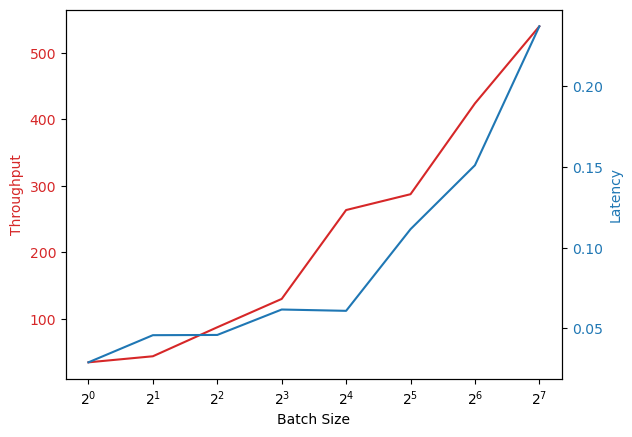

In [51]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)